In [1]:
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')

### Import data

In [2]:
mta_data = pd.read_pickle('mta_2018')

### Clean columns

In [3]:
# reset mta data index
mta_data.reset_index(drop=True,inplace=True)

# rename column EXITS
mta_data.rename(columns={'EXITS                                                               ':'EXITS'},inplace=True)

In [4]:
# Create DateTime column
mta_data['DATETIME'] = pd.to_datetime(mta_data.DATE + ' ' + mta_data.TIME)
mta_data['DATE']= pd.to_datetime(mta_data['DATE'])

# Find median_hour (center of the time slot)
# Corresponds to 2am, 6am, 10am, 14=2pm,...
mta_data['HOUR'] = (((mta_data['DATETIME'].diff()/2).shift(-1) + mta_data['DATETIME']).dt.hour)
mta_data.dropna(how='any',subset=['HOUR'],inplace=True)
mta_data['HOUR'] = mta_data['HOUR'].astype('int')

# Create Day of Week from newly create DateTime column
mta_data['WEEKDAY'] = mta_data['DATETIME'].dt.day_name()
# Create day_of_week column
mta_data['dow'] = mta_data['DATETIME'].apply(lambda x: x.weekday())


In [5]:
# Create Unique Daily ID for each turnstile
mta_data['UNIQUEID'] = mta_data['STATION'] + '_' + mta_data['UNIT'] + '_' + mta_data['C/A'] \
+ '_' + mta_data['SCP']

### Find entries for each row

In [6]:
# clean ENTRIES/EXITS as they are cumulative data
mta_data['ENTRYDIFF'] = mta_data.ENTRIES.diff()
mta_data['EXITDIFF'] = mta_data.EXITS.diff()
mta_data = mta_data[(mta_data['ENTRYDIFF'] < 100000) & (mta_data['ENTRYDIFF'] > 0)]
mta_data = mta_data[(mta_data['EXITDIFF'] < 100000) & (mta_data['EXITDIFF'] > 0)]
mta_data['TRAFFIC'] = mta_data['ENTRYDIFF'] + mta_data['EXITDIFF']

In [7]:
mta_data['TRAFFIC'].min(), mta_data['TRAFFIC'].mean(), mta_data['TRAFFIC'].max()

(2.0, 404.47821081453253, 159174.0)

In [8]:
# Find time_span (hr) between each row
# Note that most are 4.0 hrs but some are not
mta_data['DURATION'] = mta_data.DATETIME.diff().apply(lambda x: x.total_seconds()/3600)

In [9]:
# Find avg_entries (entries per hour)
mta_data['AVG_TRAFFIC'] = mta_data['TRAFFIC']/ mta_data['DURATION']

In [10]:
# Drop unnecessary columns
mta_data.drop(columns=['DATE','TIME','C/A','UNIT','SCP','LINENAME','DESC','ENTRIES','EXITS'],inplace=True)

In [11]:
mta_data.reset_index(inplace=True)
mta_data

,index,STATION,DIVISION,DATETIME,HOUR,WEEKDAY,dow,UNIQUEID,ENTRYDIFF,EXITDIFF,TRAFFIC,DURATION,AVG_TRAFFIC
0,1,59 ST,BMT,2018-05-12 04:00:00,6,Saturday,5,59 ST_R051_A002_02-00-00,19.0,5.0,24.0,NaN,NaN
1,2,59 ST,BMT,2018-05-12 08:00:00,10,Saturday,5,59 ST_R051_A002_02-00-00,19.0,31.0,50.0,4.0,12.50
2,3,59 ST,BMT,2018-05-12 12:00:00,14,Saturday,5,59 ST_R051_A002_02-00-00,105.0,85.0,190.0,4.0,47.50
3,4,59 ST,BMT,2018-05-12 16:00:00,18,Saturday,5,59 ST_R051_A002_02-00-00,219.0,49.0,268.0,4.0,67.00
4,5,59 ST,BMT,2018-05-12 20:00:00,22,Saturday,5,59 ST_R051_A002_02-00-00,297.0,50.0,347.0,4.0,86.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624525,788280,RIT-ROOSEVELT,RIT,2018-06-08 01:00:00,3,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,165.0,1.0,166.0,4.0,41.50
624526,788281,RIT-ROOSEVELT,RIT,2018-06-08 05:00:00,7,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,5.0,1.0,6.0,4.0,1.50
624527,788282,RIT-ROOSEVELT,RIT,2018-06-08 09:00:00,11,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,330.0,9.0,339.0,4.0,84.75
624528,788283,RIT-ROOSEVELT,RIT,2018-06-08 13:00:00,15,Friday,4,RIT-ROOSEVELT_R469_TRAM2_00-03-01,438.0,7.0,445.0,4.0,111.25


### Analyze data for all stations
#### Find the top busy stations

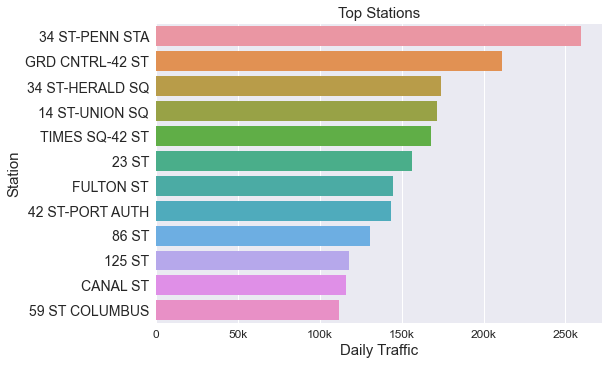

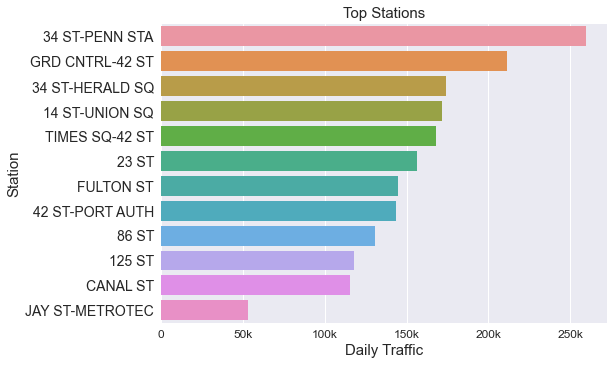

In [12]:
mta_data = mta_data[(mta_data.ENTRYDIFF < 50000) & (mta_data.EXITDIFF < 50000) & (mta_data.DURATION > 0)]

station_daily = mta_data.groupby(['STATION','dow']).sum().groupby('STATION').mean()
station_daily = station_daily['AVG_TRAFFIC']
station_daily = pd.DataFrame(station_daily)
station_daily = station_daily.dropna(how='any',subset=['AVG_TRAFFIC'])
station_daily = station_daily.reset_index()

top12 = station_daily.sort_values('AVG_TRAFFIC',ascending=False).reset_index().iloc[0:12]
top33 = station_daily.sort_values('AVG_TRAFFIC',ascending=False).reset_index().iloc[0:34]

# Generate daily traffic for top 12 stations
fig, ax = plt.subplots()
ax = sns.barplot(x="AVG_TRAFFIC", y= 'STATION', data = top12, orient='h')
ax.set_title('Top Stations',fontsize=15)
ax.set_xlabel('Daily Traffic',fontsize=15)
ax.set_ylabel('Station',fontsize=15)
ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
ax.set_xticklabels(['0','50k','100k','150k','200k','250k'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
# fig.savefig('Top_station.pdf', bbox_inches='tight')
fig.savefig('Top_station.svg', format='svg')

# Append Jay St to top12
top12_plus = top12.iloc[0:11].append(station_daily.iloc[251])

# Generate daily traffic for top 12 stations plus Jay St
fig, ax = plt.subplots()
ax = sns.barplot(x="AVG_TRAFFIC", y= 'STATION', data = top12_plus, orient='h')
ax.set_title('Top Stations',fontsize=15)
ax.set_xlabel('Daily Traffic',fontsize=15)
ax.set_ylabel('Station',fontsize=15)
ax.set_xticks([0,5e4,100e3,150e3,200e3,250e3])
ax.set_xticklabels(['0','50k','100k','150k','200k','250k'])
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
# fig.savefig('Top_station2.pdf', bbox_inches='tight')
fig.savefig('Top_station2.svg', format='svg')

### Generate rainbow plot
#### Daily traffic of top busy stations by day of week

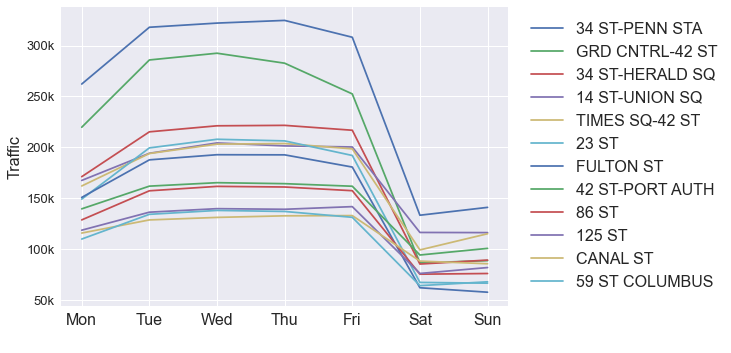

In [13]:
station_weekly = mta_data.groupby(['STATION','dow']).sum()/4 # divided by 4 since this is data for 4 weeks

station_weekly = pd.DataFrame(station_weekly).reset_index()
station_weekly['TRAFFIC'] = station_weekly['TRAFFIC'].astype(int)

# Plot together for comparison
fig, ax = plt.subplots(1,1)
# Create top_station_list
top_station_list = list(top12.iloc[0:12].STATION)
for x in top_station_list:
    ax = sns.lineplot(x='dow', y= 'TRAFFIC', data = station_weekly[station_weekly.STATION == x], label=str(x))
ax.set_title('',fontsize=17)
ax.set_xlabel(' ',fontsize=15)
ax.set_ylabel('Traffic',fontsize=16)
ax.set_xticks([0,1,2,3,4,5,6])
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_yticks([0.5e5,1e5,1.5e5,2e5,2.5e5,3e5])
ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'])
plt.legend(fontsize=16,bbox_to_anchor=(1.02, 1), loc=2)
plt.xticks(fontsize=16)
plt.yticks(fontsize=13)
# fig.savefig('Rainbow_top_station.pdf', bbox_inches='tight')
fig.savefig('Rainbow_top_station.svg', format='svg')

### Choose station

#### Define the function to generate two plots for the selected station:

#### 1. daily entry by day of week
#### 2. hourly entry for weekdays/weekends

In [14]:
def station_time_plots(station_name):
    station_df = mta_data[mta_data.STATION == station_name].iloc[1:].reset_index()
    # Filter for entries between 0 and 3000
    # Outliers come from switching to next turnstiles (should be the same as dropping first rows of each turnstile)
    # Filter out the negative values of avg_entries
    # (should be the same as dropping first value of each turnstile on a new day)
    station_filter = station_df[(station_df.TRAFFIC<100000) & (station_df.TRAFFIC>0)].copy()
    
    station_filter = station_filter[station_filter['AVG_TRAFFIC'] > 0]
    station_filter['AVG_TRAFFIC'] = station_filter['AVG_TRAFFIC'].astype(int)

    # Sum over all turnstiles
    station_total = station_filter.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()

    # Average over day
    station_total_byday = station_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
    station_total_byday['AVG_TRAFFIC'] = station_total_byday['AVG_TRAFFIC'].astype(int)

    # Day of week daily entries
    # Sum over all turnstiles
    # station_total = station_filter2.groupby(["day_of_week","median_hour"])['avg_entries'].sum().reset_index()

    # Sum over hours for one day
    station_total_byweek = station_total.groupby("dow")['AVG_TRAFFIC'].sum().reset_index()
    station_total_byweek['AVG_TRAFFIC'] = station_total_byweek['AVG_TRAFFIC'].astype(int)
    

    # Barplot showing daily entries by day of week
    fig, ax = plt.subplots()
    ax = sns.barplot(x='dow', y= 'AVG_TRAFFIC', data = station_total_byweek)
    ax.set_title('34 ST-Penn Station',fontsize=15)
    ax.set_xlabel('Day of week',fontsize=15)
    ax.set_ylabel('Traffic',fontsize=15)
    ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],fontsize=14)

    ax.set_yticks([5e4,10e4,15e4,20e4,25e4,30e4])
    ax.set_yticklabels(['50k','100k','150k','200k','250k','300k'],fontsize=12)
    fig.savefig('Traffic_dayofweek.pdf', bbox_inches='tight')

    # separate weekday/weekend
    station_weekday = station_filter[station_filter['dow'] < 5]
    station_weekend = station_filter[station_filter['dow'] >= 5]

    # Weekday data
    # Sum over all turnstiles
    station_weekday_total = station_weekday.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
    # Average over day
    station_weekday_total_byday = station_weekday_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()

    # Weekend data
    # Sum over all turnstiles
    station_weekend_total = station_weekend.groupby(["dow","HOUR"])['AVG_TRAFFIC'].sum().reset_index()
    # Average over day
    station_weekend_total_byday = station_weekend_total.groupby("HOUR")['AVG_TRAFFIC'].mean().reset_index()
    station_weekend_total_byday

    fig, ax = plt.subplots()
    temp1 = station_weekday_total_byday.set_index('HOUR')
    temp2 = station_weekend_total_byday.set_index('HOUR')
    temp1["AVG_TRAFFIC"].plot.area(label='weekday',alpha=0.6,color='cadetblue')
    temp2["AVG_TRAFFIC"].plot.area(label='weekend',alpha=0.6,color='#FF8229')
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Traffic', fontsize=15)
    plt.title(station_name,fontsize=17)
    plt.legend(fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=12)
    plt.xlim([0,22])
    ax.set_xticks([0,2,4,6,8,10,12,14,16,18,20,22])
    ax.set_yticks([1e4,2e4,3e4,4e4,5e4,6e4,7e4])
    ax.set_yticklabels(['10k','20k','30k','40k','50k','60k','70k'])
    # fig.savefig('Traffic_time.pdf', bbox_inches='tight')
    fig.savefig('Traffic_time_' + station_name +'.svg', format='svg')
    return ax

## Plot daily/hourly traffic for the final 5 stations

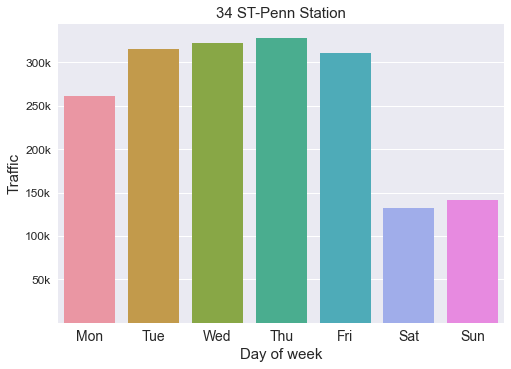

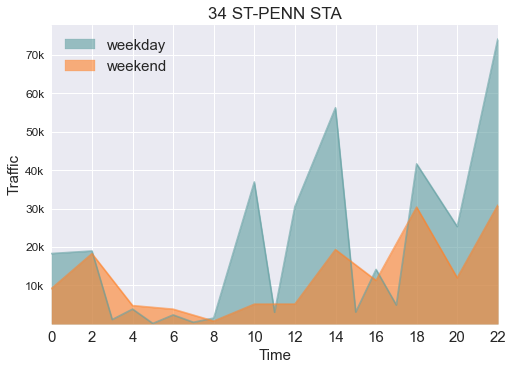

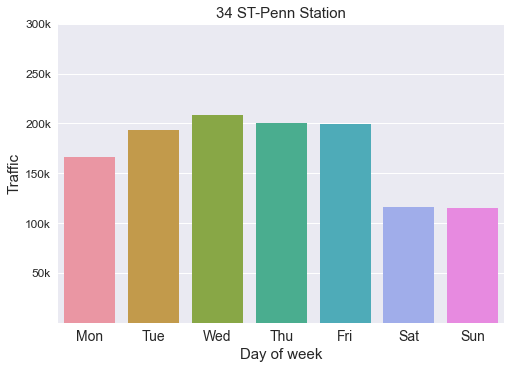

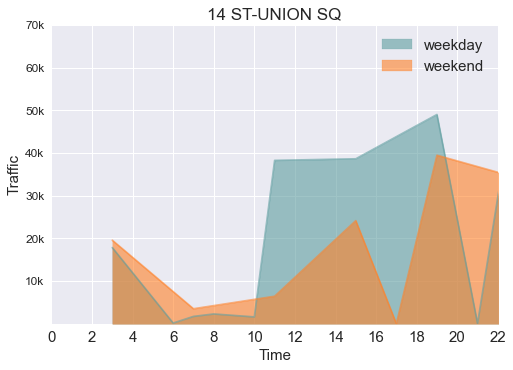

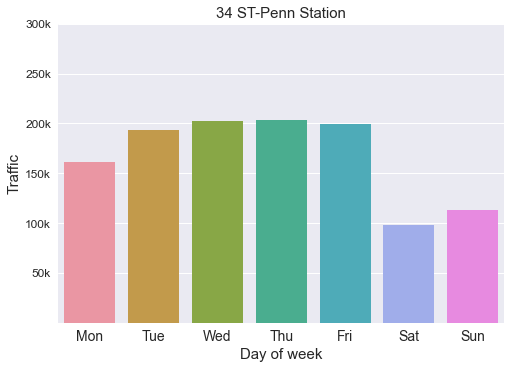

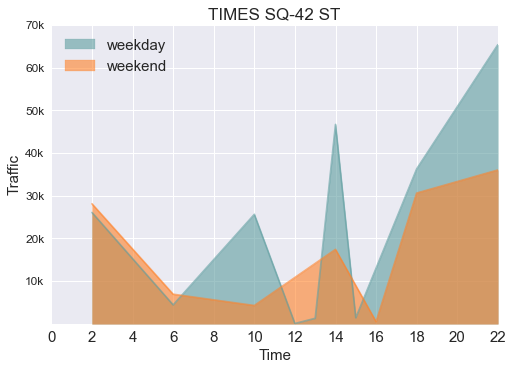

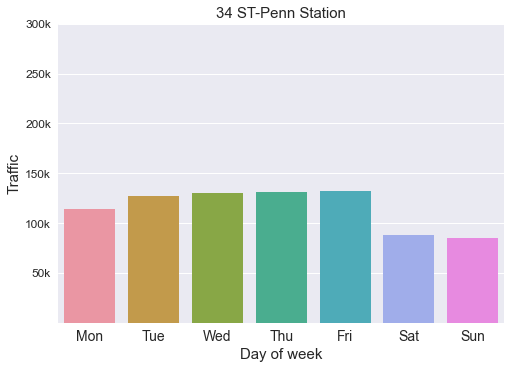

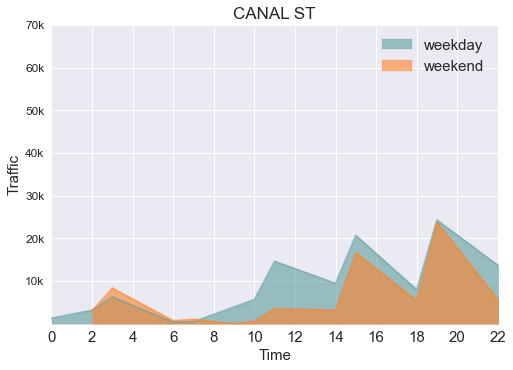

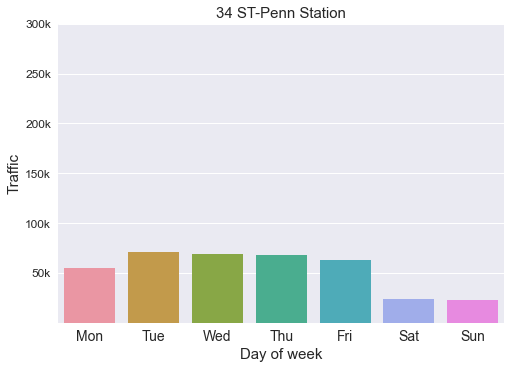

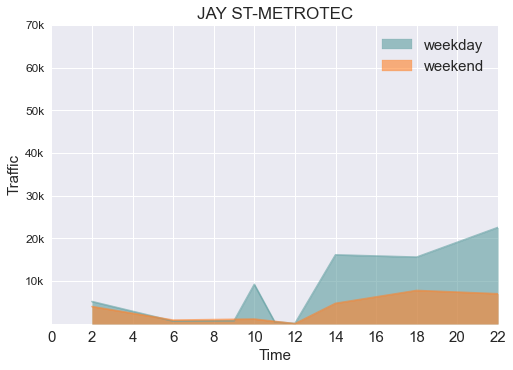

In [15]:
# Our final choice of 5 stations
final_station_list=['34 ST-PENN STA','14 ST-UNION SQ','TIMES SQ-42 ST','CANAL ST','JAY ST-METROTEC']

for x in final_station_list:
    station_time_plots(x)